In [47]:
from pandas.io.json import json_normalize
import json
import glob
import numpy as np
import pandas as pd
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors_old = cycler(color='bgrcmyk').by_key()['color']
saveimages = 1

def flatten(_list):
    return [item for sublist in _list for item in sublist]

In [48]:
def savefig(fig, lgd, file_name, _format):
    fig.savefig(f"./Figures/{file_name}.{_format}", bbox_inches='tight', format=_format, dpi=1200)
    
def savelegend(legend, file_name, _format):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"./Figures/{file_name}.{_format}", dpi=1200, bbox_inches=bbox, format=_format)

In [49]:
def plot_steps(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        iteration = data.iloc[runIdx]["iteration"]
        clusters = data.iloc[runIdx]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters))
        print("iteration: %s, clusters: %s" % (iteration, len(clusters)))
        for cIdx in range(0, len(clusters)):
            rgba_color = cm.gnuplot(norm(cIdx))
            pointsX = [point[0] for point in clusters[cIdx]["points"]]
            pointsY = [point[1] for point in clusters[cIdx]["points"]]
            ax.scatter(pointsX, pointsY, color=rgba_color)
            ax.scatter(clusters[cIdx]["centroid"][0], clusters[cIdx]["centroid"][1], color=rgba_color, marker="+")

        plt.show()

In [50]:
def plot(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        clusters_step1 = data.iloc[runIdx]["steps"][0]["clusters"]
        clusters_step2 = data.iloc[runIdx]["steps"][1]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters_step1))
        for cIdx in range(0, len(clusters_step1)):
            rgba_color = cm.gnuplot(norm(cIdx))
            ax.plot(clusters_step1[cIdx]["syntheticCenter"], "--", color=rgba_color, label="cluster %s" % cIdx)
            ax.plot(clusters_step2[cIdx]["syntheticCenter"], color=rgba_color, label="cluster %s - rescheduled" % cIdx)
            print(clusters_step2[cIdx]["metric"])
        ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)

        ax.set(xlabel='Hours', ylabel='Power (kW)',title='')
        plt.show()

In [51]:
def plot_aggm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. agg m"], "--", color=rgba_color, label="s1. agg m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. agg m"], color=rgba_color, label="s2. agg m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_maxm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. max m"], "--", color=rgba_color, label="s1. max m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. max m"], color=rgba_color, label="s2. max m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Max. Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_peak(summary, file_name=None):
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. peak"], "--", color=rgba_color, label="s1. peak")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. peak"], color=rgba_color, label="s2. peak")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Peak power (kW)',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

In [52]:
def crossfold_as_df(k, data):
    index_list = []
    step_list = []

    for i in range(0 , len(data)):
        register = data.iloc[i]

        crossfold = json_normalize(register["crossfold"])
        splits = crossfold["splits"].values[0]
        steps = data.iloc[i]["step"]
        for j in range(0, splits):
            step = json_normalize(steps[j])
            for ki in range(1, k+1):
                index_list.append((float("{0:.2f}".format(crossfold["sampleSize"].values[0])), j, ki))
                step_list.append(step.iloc[ki-1])


    json_normalize(data.iloc[0]["crossfold"])
    json_normalize(data.iloc[0]["step"][0])

    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "split", "k"])
    return pd.DataFrame(step_list, index=index)

# PAR Aggregate

In [53]:
#summaryBatch_global = pd.read_json("./files/scheduler_tests/complete_2.9c/summaryBatch.json")

exp1_splits = 200
exp1_k = 6
exp1_sample_size_min = 0.5
exp1_sample_size_max = 1.0
exp1_nsteps = 2

def sample_size_range(sample_size_min, sample_size_max):
    return (x/10 for x in range(int(sample_size_min * 10), int((sample_size_max * 10) + 1)))

In [54]:
# result = []
# for f in glob.glob("./files/scheduler_tests/complete_v3.0/*/*.json"):
#     with open(f, "r") as infile:
#         result.append(json.load(infile))

# r = []
# for sampleSizeIdx, sampleSize in enumerate(sample_size_range(exp1_sample_size_min, exp1_sample_size_max)):
#     steps = []
#     for batch in result:
#         steps.append(batch[sampleSizeIdx]["step"])
    
#     steps = sorted(steps, key=lambda x: x[0][0]["k"])
        
#     list_of_splits = []
#     for split in range(0, exp1_splits):
#         list_of_split = []
#         for ki in range(0, exp1_k):
#             item = steps[ki].pop()
#             list_of_split.append(item[0])
#         #sorted(list_of_split.
#         list_of_splits.append(list_of_split)
    
#     r.append({"crossfold": {"splits" : 200, "sampleSize": sampleSize}, "step": list_of_splits})

# with open("./files/scheduler_tests/complete_v3.0/merged_file.json", "w") as outfile:
#      json.dump(r, outfile)
# summaryBatch_global = pd.read_json("./files/scheduler_tests/complete_v3.0/merged_file.json")

In [100]:
#summaryBatch_global = pd.read_json("./files/scheduler_tests/complete_2.9c/summaryBatch.json")
import itertools

directory = "synthetic_11-05-2020"

exp1_splits = 200
exp1_k = 6
exp1_sample_size_min = 0.5
exp1_sample_size_max = 1.0
exp1_nsteps = 2

def sample_size_range(sample_size_min, sample_size_max):
    return (x/10 for x in range(int(sample_size_min * 10), int((sample_size_max * 10) + 1)))

result = []
for f in glob.glob(f"./files/scheduler_tests/{directory}/summary*.json"):
    with open(f, "r") as infile:
        result.append(json.load(infile))

r = []

#print(list(enumerate(sample_size_range(exp1_sample_size_min, exp1_sample_size_max))))

for sampleSizeIdx, sampleSize in enumerate(sample_size_range(exp1_sample_size_min, exp1_sample_size_max)):
    steps = []
    l = [ batch[0]["step"] for batch in result if batch[0]["crossfold"]["sampleSize"] == sampleSize]
    # Flatten list
    steps_ks = [item for sublist in l for item in sublist]
    
    print(len(steps_ks))
    
    for ki in range(0, exp1_k):
        step_k = [item for ks in steps_ks for item in ks if item["k"] == ki + 1]
        steps.append(step_k)
    
    steps = sorted(steps, key=lambda x: x[0]["k"])
        
    list_of_splits = []
    for split in range(0, exp1_splits):
        list_of_split = []
        for ki in range(0, exp1_k):
            item = steps[ki].pop()
            list_of_split.append(item)
        #sorted(list_of_split.
        list_of_splits.append(list_of_split)
    
    r.append({"crossfold": {"splits" : 200, "sampleSize": sampleSize}, "step": list_of_splits})

with open(f"./files/scheduler_tests/{directory}/merged_file.json", "w") as outfile:
     json.dump(r, outfile)
summaryBatch_global = pd.read_json(f"./files/scheduler_tests/{directory}/merged_file.json")
summaryBatch_global

200
200
200
200
200
200


,crossfold,step
0,"{'splits': 200, 'sampleSize': 0.5}","[[{'k': 1, 's1. peak': 2089858, 's1. agg m': 1..."
1,"{'splits': 200, 'sampleSize': 0.6000000000000001}","[[{'k': 1, 's1. peak': 2205512, 's1. agg m': 1..."
2,"{'splits': 200, 'sampleSize': 0.7000000000000001}","[[{'k': 1, 's1. peak': 2797391, 's1. agg m': 1..."
3,"{'splits': 200, 'sampleSize': 0.8}","[[{'k': 1, 's1. peak': 3107674, 's1. agg m': 1..."
4,"{'splits': 200, 'sampleSize': 0.9}","[[{'k': 1, 's1. peak': 3457269, 's1. agg m': 1..."
5,"{'splits': 200, 'sampleSize': 1.0}","[[{'k': 1, 's1. peak': 3903617, 's1. agg m': 1..."


In [101]:
exp1_treated = crossfold_as_df(exp1_k, summaryBatch_global)
k2 = 2
query = f"k == {k2} and sampleSize == {exp1_sample_size_min}"
exp1_treated.query(query)["s1. agg m"].mean()
exp1_treated.query(query)["s1. max m"].mean()
exp1_treated.query(query)["s1. peak"].std()
exp1_treated.rename(columns={"s2. total m": "s2TotalM", "s2. agg m": "s2AggM", "s2. total peak": "s2TotalPeak", "s1. total peak": "s1TotalPeak"}, inplace=True)
exp1_treated.drop("k",axis=1,inplace=True)
exp1_treated[:20]
#exp1_treated.query("k == 6 and sampleSize == 1.0")["s2AggM"].mean()
#exp1_statistics.rename(columns={"s2. total m": "s2TotalM", "s2. agg m": "s2AggM"}, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


s1. peak  s1. agg m  s1. max m  s1. total m  s1TotalPeak  \
sampleSize split k                                                             
0.5        0     1   2089858   1.518927   1.518927     1.518927      2089858   
                 2   1085553   1.015092   1.553931     1.518927      2089858   
                 3    813518   1.011231   1.584978     1.518927      2089858   
                 4    657452   1.195695   1.919249     1.518927      2089858   
                 5    693528   1.200802   2.182601     1.518927      2089858   
                 6    473354   1.225167   2.293917     1.518927      2089858   
           1     1   1924606   1.403591   1.403591     1.403591      1924606   
                 2   1100406   1.029905   1.617931     1.403591      1924606   
                 3   1049137   1.024909   1.713802     1.403591      1924606   
                 4   1047973   1.154710   2.189141     1.403591      1924606   
                 5   1006512   1.107333   2.503413     1.403591      1924606   
                 6    589282   1.145491   2.158424     1.403591      1924606   
           2     1   2034394   1.401193   1.401193     1.401193      2034394   
                 2   1150293   1.020949   1.521399     1.401193      2034394   
                 3    913839   1.099448   1.837811     1.401193      2034394   
                 4   1238312   1.162802   2.235631     1.401193      2034394   
                 5    964185   1.089475   2.311504     1.401193      2034394   
                 6    658785   1.184043   2.261727     1.401193      2034394   
           3     1   2062570   1.391744   1.391744     1.391744      2062570   
                 2   1229106   1.001673   1.520388     1.391744      2062570   

                                    clusters  s2. peak    s2AggM  s2. max m  \
sampleSize split k                                                            
0.5        0     1                     [100]   1904565  1.384254   1.384254   
                 2                  [50, 50]    983380  1.006544   1.426219   
                 3              [34, 33, 33]    787664  1.041913   1.539191   
                 4          [25, 25, 25, 25]    620049  1.146646   1.761415   
                 5      [20, 20, 20, 20, 20]    601575  1.166838   1.963451   
                 6  [17, 17, 17, 17, 16, 16]    435135  1.156278   2.023385   
           1     1                     [100]   1859609  1.356190   1.356190   
                 2                  [50, 50]   1100406  1.017350   1.577789   
                 3              [34, 33, 33]   1049137  1.061193   1.713802   
                 4          [25, 25, 25, 25]   1047973  1.164707   2.189141   
                 5      [20, 20, 20, 20, 20]   1006512  1.081176   2.280258   
                 6  [17, 17, 17, 17, 16, 16]    589282  1.138501   2.115715   
           2     1                     [100]   1987357  1.368796   1.368796   
                 2                  [50, 50]   1150293  1.007804   1.458964   
                 3              [34, 33, 33]    818779  1.111486   1.767650   
                 4          [25, 25, 25, 25]   1238312  1.207527   2.235631   
                 5      [20, 20, 20, 20, 20]    964185  1.093312   2.311504   
                 6  [17, 17, 17, 17, 16, 16]    658785  1.181299   2.133876   
           3     1                     [100]   2049881  1.383182   1.383182   
                 2                  [50, 50]   1229106  1.039006   1.515309   

                    s2TotalM  s2TotalPeak  userDiss  
sampleSize split k                                   
0.5        0     1  1.384254      1904565       853  
                 2  1.384254      1904565       828  
                 3  1.384254      1904565       785  
                 4  1.417266      1949985       877  
                 5  1.390540      1913214       700  
                 6  1.384254      1904565       436  
           1     1  1.356190      1859609       860  
                 2  1.385699      

In [102]:
def get_statistics(k, nSteps, treated, sample_size_min, sample_size_max):
    index_list = []
    step_list = []

    for j in range(1, k+1):
        for ssize in sample_size_range(sample_size_min, sample_size_max):

            index_list.append((ssize, "mean", j))
            query = f"k == {j} and sampleSize == {ssize}"
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            data = {key: treated.query(query)[key].mean() for key in index}
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].mean(),
                    "s1. max m" : treated.query(query)["s1. max m"].mean(), 
                    "s1. peak" : treated.query(query)["s1. peak"].mean()/1, # units!
                   "s1. total m" : treated.query(query)["s1. total m"].mean(),
                   "s1TotalPeak" : treated.query(query)["s1TotalPeak"].mean()/1} #units!
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m", "s1TotalPeak"]
            if (nSteps >= 2):
                data.update({"s2AggM" : treated.query(query)["s2AggM"].mean(),
                    "s2. max m" : treated.query(query)["s2. max m"].mean(), 
                    "s2. peak" : treated.query(query)["s2. peak"].mean()/1000,
                    "s2TotalM" : treated.query(query)["s2TotalM"].mean(),
                    "s2TotalPeak" : treated.query(query)["s2TotalPeak"].mean()/1000,
                    "userDiss": treated.query(query)["userDiss"].mean()})
                index = index + ["s2AggM","s2. max m","s2. peak", "s2TotalM", "s2TotalPeak", "userDiss"]

            s = pd.Series(data,index=index) 
            step_list.append(s)
            #print(f"sampleSize = {ssize}, k = {j}")

            index_list.append((ssize, "stdv", j))
            query = f"k == {j} and sampleSize == {ssize}"
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].std(),
                    "s1. max m" : treated.query(query)["s1. max m"].std(), 
                    "s1. peak" : treated.query(query)["s1. peak"].std(),
                   "s1. total m" : treated.query(query)["s1. total m"].std(),
                   "s1TotalPeak" : treated.query(query)["s1TotalPeak"].std()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m", "s1TotalPeak"]
            if (nSteps >= 2):
                data.update({"s2AggM" : treated.query(query)["s2AggM"].std(),
                    "s2. max m" : treated.query(query)["s2. max m"].std(), 
                    "s2. peak" : treated.query(query)["s2. peak"].std(),
                    "s2TotalM" : treated.query(query)["s2TotalM"].std(),
                    "s2TotalPeak" : treated.query(query)["s2TotalPeak"].std(),
                    "userDiss": treated.query(query)["userDiss"].std()})
                index = index + ["s2AggM","s2. max m","s2. peak", "s2TotalM", "s2TotalPeak", "userDiss"]

            s = pd.Series(data,index=index) 
            step_list.append(s)
            
            index_list.append((ssize, "median", j))
            query = f"k == {j} and sampleSize == {ssize}"
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].median(),
                    "s1. max m" : treated.query(query)["s1. max m"].median(), 
                    "s1. peak" : treated.query(query)["s1. peak"].median(),
                   "s1. total m" : treated.query(query)["s1. total m"].median(),
                   "s1TotalPeak" : treated.query(query)["s1TotalPeak"].median()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m", "s1TotalPeak"]
            if (nSteps >= 2):
                data.update({"s2AggM" : treated.query(query)["s2AggM"].median(),
                    "s2. max m" : treated.query(query)["s2. max m"].median(), 
                    "s2. peak" : treated.query(query)["s2. peak"].median(),
                    "s2TotalM" : treated.query(query)["s2TotalM"].median(),
                    "s2TotalPeak" : treated.query(query)["s2TotalPeak"].median(),
                    "userDiss": treated.query(query)["userDiss"].median()})
                index = index + ["s2AggM","s2. max m","s2. peak", "s2TotalM", "s2TotalPeak", "userDiss"]

            s = pd.Series(data,index=index) 
            step_list.append(s)


    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "metric", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_statistics = get_statistics(exp1_k,exp1_nsteps, exp1_treated, exp1_sample_size_min, exp1_sample_size_max)
exp1_statistics

s1. agg m  s1. max m      s1. peak   s1. total m  \
sampleSize metric k                                                     
0.5        mean   1   1.476561   1.476561  2.040981e+06  1.476561e+00   
           stdv   1   0.104613   0.104613  1.546870e+05  1.046126e-01   
           median 1   1.459519   1.459519  2.008710e+06  1.459519e+00   
0.6        mean   1   1.458776   1.458776  2.398647e+06  1.458776e+00   
           stdv   1   0.094809   0.094809  1.287636e+05  9.480862e-02   
...                        ...        ...           ...           ...   
0.9        stdv   6   0.072073   0.168676  1.831667e+05  5.310688e-02   
           median 6   1.176436   2.075094  9.127640e+05  1.415256e+00   
1.0        mean   6   1.184823   2.038491  1.053191e+06  1.415407e+00   
           stdv   6   0.075708   0.168917  2.013148e+05  4.452036e-16   
           median 6   1.169839   2.048976  1.047682e+06  1.415407e+00   

                      s1TotalPeak    s2AggM  s2. max m      s2. peak  \
sampleSize metric k                                                    
0.5        mean   1  2.040981e+06  1.420077   1.420077  1.965659e+03   
           stdv   1  1.546870e+05  0.092911   0.092911  1.765079e+05   
           median 1  2.008710e+06  1.406928   1.406928  1.943320e+06   
0.6        mean   1  2.398647e+06  1.394376   1.394376  2.294959e+03   
           stdv   1  1.287636e+05  0.080775   0.080775  1.463973e+05   
...                           ...       ...        ...           ...   
0.9        stdv   6  8.032372e+04  0.070230   0.158027  1.881232e+05   
           median 6  3.524411e+06  1.176069   1.967254  9.115950e+05   
1.0        mean   6  3.903617e+06  1.177748   1.946356  1.044852e+03   
           stdv   6  0.000000e+00  0.071312   0.168248  2.096257e+05   
           median 6  3.903617e+06  1.167046   1.925165  1.047682e+06   

                     s2TotalM   s2TotalPeak     userDiss  
sampleSize metric k                                       
0.5        mean   1  1.420077  1.965659e+03   756.385000  
           stdv   1  0.092911  1.765079e+05   182.678251  
           median 1  1.406928  1.943320e+06   744.000000  
0.6        mean   1  1.394376  2.294959e+03   903.705000  
           stdv   1  0.080775  1.463973e+05   213.137505  
...                       ...           ...          ...  
0.9        stdv   6  0.040838  8.096610e+04   163.786785  
           median 6  1.355585  3.365973e+06  1261.000000  
1.0        mean   6  1.345433  3.710633e+03  1432.370000  
           stdv   6  0.013933  3.842517e+04   171.847464  
           median 6  1.337737  3.689407e+06  1419.500000  

[108 rows x 11 columns]

In [103]:
def get_metrics(k, metric, metric_type, statistics, sample_size_min, sample_size_max):

    index_list = [sample_size_range(sample_size_min, sample_size_max)]
    cols = [x for x in range(1, k+1)]
    step_list = []

    for ssize in sample_size_range(sample_size_min, sample_size_max):
        query = f"sampleSize == {ssize} and metric == \"{metric_type}\" "
        dataAllK = statistics.query(query)[f"{metric}"]
        dictAllK = {}
        for j in range(1, k+1):
            d = dataAllK.reset_index().query(f"k == {j}")[f"{metric}"]
            dictAllK[f"{j}"] = d.values[0]
        s = pd.Series(dictAllK, name=f"{ssize}")
        step_list.append(s)

    return pd.DataFrame(step_list)
    

In [104]:
mname = "s2TotalM"
mtype = "mean"
s2_total_m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)
s2_total_m

mname = "userDiss"
mtype = "mean"
s1_total_m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)
s1_total_m

,1,2,3,4,5,6
0.5,756.385,762.395,747.675,661.565,609.255,608.775
0.6,903.705,926.450,904.985,827.000,754.670,712.555
0.7,1059.070,1062.980,1072.730,1043.525,959.515,883.675
0.8,1212.280,1231.195,1227.320,1194.595,1133.765,1055.400
0.9,1349.405,1387.940,1341.420,1325.990,1315.565,1258.640
1.0,1408.000,1553.075,1490.915,1498.145,1494.615,1432.370


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


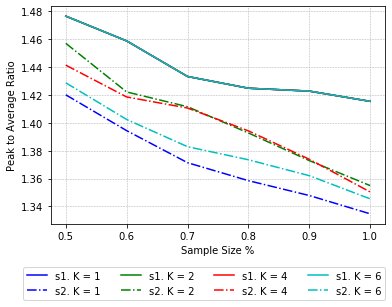

In [105]:
def plot_mean_par_s1_s2(k):
    mtype = "mean"
    
    mname = "s2TotalM"
    s2_total_m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)
    
    mname = "s1. total m"
    s1_total_m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)

    fig, ax = plt.subplots()
    
    for idx, k_idx in enumerate([1] + list(range(2, k+1, 2))):
        sampleMaxMDataset = s1_total_m[str(k_idx)]
        sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
        values_1 = sampleMaxMDataset.values
        ax.plot(sampleSizes, values_1, "-", label=f"s1. K = {k_idx}", c=colors_old[idx])
        
        sampleMaxMDataset = s2_total_m[str(k_idx)]
        sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
        values_2 = sampleMaxMDataset.values
        ax.plot(sampleSizes, values_2, "-.", label=f"s2. K = {k_idx}", c=colors_old[idx])
    
    ax.tick_params(axis='x', which='major')
    lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0., mode=None, ncol=4)
    ax.set(xlabel='Sample Size %', ylabel='Peak to Average Ratio',title='')
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', linewidth='0.5')
    
    return (fig, ax, lgd)
    
fig, ax, lgd = plot_mean_par_s1_s2(exp1_k)

if saveimages == 1:
    file_name = "peaktoaverageratio_samplesize"
    if file_name is not None:
        savefig(fig, lgd, file_name, "pdf")
        savefig(fig, lgd, file_name, "eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


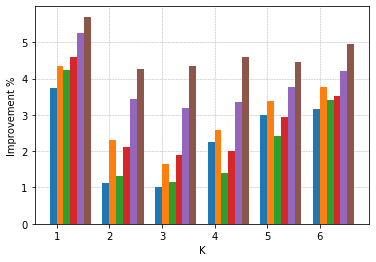

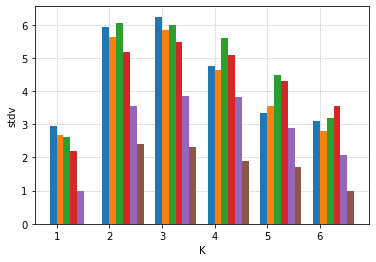

In [106]:
def improvement_ratio(x):
    return list(map(lambda xy: (1 - xy[0]/xy[1]) * 100,zip(x["s2TotalM"], x["s1. total m"])))

def plot_improvement_ratio(treated, k, sample_size_range):  
    treated_working_copy = treated.copy()
    improvement_ratio_grouped = treated_working_copy.groupby(["sampleSize", 'k']).apply(improvement_ratio).to_frame().reset_index()
    improvement_ratio_grouped.rename(columns={0: "values"},inplace=True)
    improvement_ratio_grouped["mean"] = improvement_ratio_grouped["values"].apply(lambda x: np.array(x).mean())
    improvement_ratio_grouped["stdv"] = improvement_ratio_grouped["values"].apply(lambda x: np.array(x).std())
    
    fig_mean, ax_mean = plt.subplots()
    fig_stdv, ax_stdv = plt.subplots()
    ax_mean.set_axisbelow(True)
    ax_stdv.set_axisbelow(True)
    
    ax_mean.grid(True, linestyle='--', linewidth='0.5')
    ax_stdv.grid(True, linestyle='--', linewidth='0.5')    
    
    ind = np.arange(k)    # the x locations for the groups
    width = 0.13        # the width of the bars

    bars = []
        
    for idx, ssize in enumerate(sample_size_range):
        sample_size_batch = improvement_ratio_grouped.query(f"sampleSize == {ssize}")
        means = sample_size_batch["mean"]
        stdvs = sample_size_batch["stdv"]
        ax_mean.bar(ind + idx*width, means, width, yerr=None, label=str(ssize), color=colors[idx])
        ax_stdv.bar(ind + idx*width, stdvs, width, yerr=None, label=str(ssize), color=colors[idx])
        labels = list(map(lambda x: str(x), list(range(1, k+1))))


        ax_mean.set_xticks(ind + width / 2)
        ax_mean.set_xticklabels(labels)
        ax_mean.set_ylabel('Improvement %')
        ax_mean.set_xlabel('K')
        

        ax_stdv.set_xticks(ind + width / 2)
        ax_stdv.set_xticklabels(labels)
        ax_stdv.set_ylabel('stdv')
        ax_stdv.set_xlabel('K')

    lgd_mean = ax_mean.legend(title="Sample Size %", bbox_to_anchor=(1, -0.40), loc=4, borderaxespad=0., ncol=3)
    lgd_stdv = ax_stdv.legend(title="Sample Size %", bbox_to_anchor=(1, -0.40), loc=4, borderaxespad=0., ncol=3)
    
    return {"mean": (fig_mean, ax_mean, lgd_mean), "stdv": (fig_stdv, ax_stdv, lgd_stdv)}
    
figs = plot_improvement_ratio(exp1_treated, exp1_k, sample_size_range(exp1_sample_size_min, exp1_sample_size_max))

mean_fig = figs["mean"]

stdv_fig = figs["stdv"]

savelegend(stdv_fig[2], "s1_s2_improvement_legend", "pdf")
savelegend(stdv_fig[2], "s1_s2_improvement_legend", "eps")

mean_fig[2].remove()
stdv_fig[2].remove()

savefig(mean_fig[0], mean_fig[1], "s1_s2_improvement_mean_no_legend", "pdf")
savefig(mean_fig[0], mean_fig[1], "s1_s2_improvement_mean_no_legend", "eps")
savefig(stdv_fig[0], stdv_fig[1], "s1_s2_improvement_stdv_no_legend", "pdf")
savefig(stdv_fig[0], stdv_fig[1], "s1_s2_improvement_stdv_no_legend", "eps")

In [107]:
def show_summary2(k, summary_treated, statistics, sample_size):
    _list_clusters = {}
    _list_max_toal_m = {}
    _list_min_toal_m = {}
    _list_above_s1agg_m = {}
    _list_below_s1agg_m = {}
    rows_per_k = summary_treated.query(f"sampleSize == {sample_size} and k == 1").reset_index(drop=True).count().iloc[0]
    k1_s1_agg_m = statistics.query(f"sampleSize == {sample_size} and metric == \"mean\" and k == 1").reset_index().drop(["sampleSize", "metric"], axis=1)["s1. agg m"]
    
    for j in range(1, k+1):
        _list_clusters[j - 1] = str(summary_treated.query(f"sampleSize == {sample_size} and k == {j}").sort_values(by=["s1. max m", "s1. agg m"]).iloc[0]["clusters"])
        _list_max_toal_m[j - 1] = summary_treated.query(f"sampleSize == {sample_size} and k == {j}").sort_values(by=["s2TotalM"],ascending=False).iloc[0]["s2TotalM"]
        _list_min_toal_m[j - 1] = summary_treated.query(f"sampleSize == {sample_size} and k == {j}").sort_values(by=["s2TotalM"],ascending=True).iloc[0]["s2TotalM"]
        _list_above_s1agg_m[j - 1] = summary_treated.query(f"sampleSize == {sample_size} and s2TotalM >= {k1_s1_agg_m.values[0]} and k == {j}").reset_index(drop=True).count().iloc[0] / rows_per_k
        _list_below_s1agg_m[j - 1] = summary_treated.query(f"sampleSize == {sample_size} and s2TotalM < {k1_s1_agg_m.values[0]} and k == {j}").reset_index(drop=True).count().iloc[0] / rows_per_k
    a = statistics.query(f"sampleSize == {sample_size} and metric == \"mean\"").reset_index().drop(["sampleSize", "metric"], axis=1)
    b = pd.DataFrame.from_dict(_list_clusters, orient="index", columns=["clusters"])
    c = pd.DataFrame.from_dict(_list_max_toal_m, orient="index", columns=["s2. total max m"])
    d = pd.DataFrame.from_dict(_list_min_toal_m, orient="index", columns=["s2. total min m"])
    e = pd.DataFrame.from_dict(_list_above_s1agg_m, orient="index", columns=["s2TotalAboveM"])
    f = pd.DataFrame.from_dict(_list_below_s1agg_m, orient="index", columns=["s2TotalBelowM"])
    r = pd.concat([a,b,c,d,e,f], axis=1, sort=False)
    #r = r[["k", "s1. agg m", "s1. max m", "s1. peak", "s2AggM", "s2. max m", "s2. peak", "s2TotalM", "s2. total max m", "s2. total min m", "s2TotalBelowN"]]
    return r

r = show_summary2(exp1_k, exp1_treated, exp1_statistics, '1.0')
k1_s1_agg_m = exp1_statistics.query("sampleSize == 1.0 and metric == \"mean\" and k == 1").reset_index().drop(["sampleSize", "metric"], axis=1)["s1. agg m"]
#r1 = exp1_treated_copy.query("sampleSize == 1.0").reset_index().drop(["sampleSize", "metric"], axis=1)
#r1
r


,k,s1. agg m,s1. max m,s1. peak,s1. total m,s1TotalPeak,s2AggM,s2. max m,s2. peak,s2TotalM,s2TotalPeak,userDiss,clusters,s2. total max m,s2. total min m,s2TotalAboveM,s2TotalBelowM
0,1,1.415407,1.415407,3903617.000,1.415407,3903617.0,1.334687,1.334687,3680.996000,1.334687,3680.996000,1408.000,[200],1.334687,1.334687,0.000,1.000
1,2,1.045810,1.562810,2160850.515,1.415407,3903617.0,1.030114,1.487198,2099.797055,1.354938,3736.847925,1553.075,"[100, 100]",1.544501,1.334687,0.085,0.915
2,3,1.075826,1.679460,1603100.630,1.415407,3903617.0,1.064485,1.603026,1578.070690,1.353800,3733.710455,1490.915,"[67, 67, 66]",1.513398,1.334687,0.065,0.935
3,4,1.122267,1.813960,1317767.510,1.415407,3903617.0,1.110051,1.727634,1302.376755,1.350384,3724.287835,1498.145,"[50, 50, 50, 50]",1.491840,1.334687,0.040,0.960
4,5,1.155131,1.933728,1162007.565,1.415407,3903617.0,1.152981,1.851561,1154.359555,1.352235,3729.392055,1494.615,"[40, 40, 40, 40, 40]",1.491961,1.334687,0.035,0.965
5,6,1.184823,2.038491,1053190.510,1.415407,3903617.0,1.177748,1.946356,1044.851740,1.345433,3710.633045,1432.370,"[34, 34, 33, 33, 33, 33]",1.409796,1.334687,0.000,1.000


# Quartiles

In [108]:
def compute_quartiles(treated, statistics, k, sample_size_range):
    return_data = []
    all_sample_sizes = []
    for idx, sample_size in enumerate(sample_size_range):
        summary = show_summary2(k, treated, statistics, sample_size)
        
        data = [treated.query(f"sampleSize == {sample_size} and k == {i + 1}")["s2TotalM"].values for i in range(0, k)]
        k1_s1_agg_m = summary.query("k == 1").reset_index()["s1. max m"].values[0]
        k1_s2_agg_m = summary.query("k == 1").reset_index()["s2. total min m"].values[0]
        
        data_for_storage = {
            "data": data,
            "k1_s1_agg_m": k1_s1_agg_m,
            "k1_s2_agg_m": k1_s2_agg_m
        }
        
        return_data.append({"ssize": sample_size, "data": data_for_storage})
        
        df_sample_size = []
        
        for k_idx in range(0, k):
            s1 = k1_s1_agg_m
            s2 = k1_s2_agg_m
            d = data[k_idx]
            
            
            whis=1.5
            q75, q50, q25 = np.percentile(d, [75, 50, 25])
            iqr = q75 - q25
            ufence = q75 + whis * iqr
            lfence = q25 - whis * iqr
            
            uwhisker = next((x for x in np.sort(d)[::-1] if x <= ufence), q50)
            lwhisker = next((x for x in np.sort(d) if x >= lfence), q50)
            #print(uwhisker)
            #print(lwhisker)

            
            columns=["Q1", "Q2", "Q3", "LW", "UW"]
            quartiles = [q25, q50, q75, lwhisker, uwhisker]
            dictionary = dict(zip(["Q1", "Q2", "Q3", "LW", "UW"], map(lambda x: [x], quartiles)))
            index = pd.MultiIndex.from_tuples([(sample_size, s1, s2, k_idx)], names=['sampleSize', 's1', 's2', 'k'])
    
            df_sample_size.append(pd.DataFrame(dictionary, columns=columns, index=index))
            
        all_sample_sizes.append(pd.concat(df_sample_size))
        
    return_quartiles = pd.concat(all_sample_sizes)
        
    return (return_data, return_quartiles)

def sample_size_boxplot(sample_size_data):    
    data = sample_size_data["data"]["data"]
    s1 = sample_size_data["data"]["k1_s1_agg_m"]
    s2 = sample_size_data["data"]["k1_s2_agg_m"]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', linewidth='0.5')
    plt.axhline(y= s1, color='r', linestyle='-', label=f"s1. PAR for K = 1")
    plt.axhline(y= s2, color='b', linestyle='-.', label=f"s2. PAR for K = 1")
    plot = ax.boxplot(data, labels= list(range(1, len(data) + 1)), whis=1.5)
    lgd = ax.legend(bbox_to_anchor=(1, -0.45), loc=4, borderaxespad=0.)
    ax.set(xlabel='K', ylabel='Peak to Average Ratio',title='')
    
    return (fig, ax, lgd)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

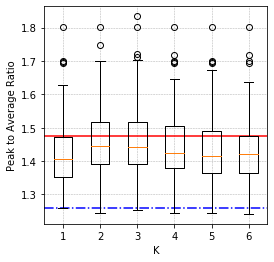

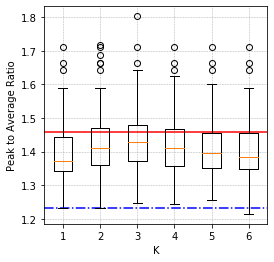

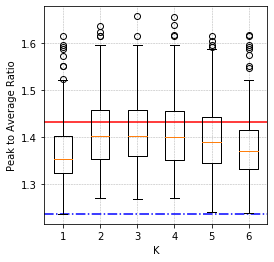

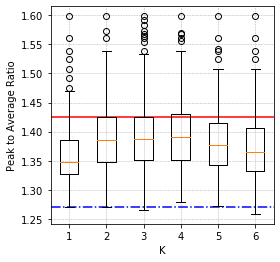

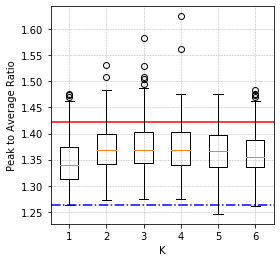

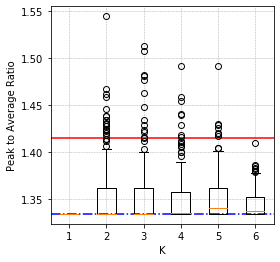

In [109]:
all_data, quartiles = compute_quartiles(exp1_treated, exp1_statistics, exp1_k, sample_size_range(exp1_sample_size_min, exp1_sample_size_max))
for data in all_data:
    fig, ax, lgd = sample_size_boxplot(data)
    ssize = data["ssize"]
    if saveimages == 1:
        savelegend(lgd, f"boxplot_samplesize_par_legend", "pdf")
        savelegend(lgd, f"boxplot_samplesize_par_legend", "eps")
        savefig(fig, lgd, f"boxplot_samplesize_par_{int(ssize*100)}_no_legend", "pdf")
        savefig(fig, lgd, f"boxplot_samplesize_par_{int(ssize*100)}_no_legend", "eps")
        lgd.remove()
        savefig(fig, lgd, f"boxplot_samplesize_par_{int(ssize*100)}_no_legend", "pdf")
        savefig(fig, lgd, f"boxplot_samplesize_par_{int(ssize*100)}_no_legend", "eps")
        

In [110]:
with open('quartiles_samplesize_par.tex', 'w') as tf:
     tf.write(quartiles.to_latex())
quartiles

Q1        Q2        Q3        LW  \
sampleSize s1       s2       k                                           
0.5        1.476561 1.258130 0  1.351815  1.406928  1.472327  1.258130   
                             1  1.390978  1.444077  1.517741  1.245823   
                             2  1.392340  1.442595  1.516658  1.253014   
                             3  1.378957  1.423510  1.504056  1.245464   
                             4  1.364376  1.414336  1.488763  1.245823   
                             5  1.364608  1.420622  1.474435  1.241739   
0.6        1.458776 1.232789 0  1.340842  1.371682  1.444324  1.232789   
                             1  1.358804  1.411218  1.470119  1.232789   
                             2  1.370978  1.427958  1.480479  1.248250   
                             3  1.358060  1.411856  1.467567  1.242598   
                             4  1.349693  1.394332  1.455088  1.256128   
                             5  1.349618  1.382755  1.454879  1.214469   
0.7        1.433251 1.237585 0  1.323587  1.355038  1.403158  1.237585   
                             1  1.354700  1.402824  1.458389  1.271085   
                             2  1.360993  1.403218  1.457083  1.269888   
                             3  1.352906  1.401674  1.456194  1.270706   
                             4  1.345744  1.390505  1.443646  1.242281   
                             5  1.332852  1.370447  1.414722  1.239641   
0.8        1.424822 1.270350 0  1.326680  1.347395  1.385688  1.270350   
                             1  1.348063  1.385621  1.425152  1.270350   
                             2  1.351197  1.388024  1.425567  1.265374   
                             3  1.350573  1.390933  1.429960  1.278618   
                             4  1.341774  1.376662  1.414568  1.271229   
                             5  1.331886  1.365688  1.406310  1.258475   
0.9        1.422761 1.263538 0  1.312630  1.340274  1.374915  1.263538   
                             1  1.342463  1.368350  1.400057  1.273502   
                             2  1.343487  1.369080  1.403977  1.273744   
                             3  1.339363  1.368877  1.403438  1.274855   
                             4  1.334998  1.367533  1.397658  1.245966   
                             5  1.335267  1.355585  1.387279  1.260956   
1.0        1.415407 1.334687 0  1.334687  1.334687  1.334687  1.334687   
                             1  1.334687  1.334687  1.362130  1.334687   
                             2  1.334687  1.335078  1.361870  1.334687   
                             3  1.334687  1.335727  1.358367  1.334687   
                             4  1.334687  1.341350  1.361830  1.334687   
                             5  1.334687  1.337737  1.352289  1.334687   

                                      UW  
sampleSize s1       s2       k            
0.5        1.476561 1.258130 0  1.627334  
                             1  1.698892  
                             2  1.703101  
                             3  1.647282  
                             4  1.673933  
                             5  1.638118  
0.6        1.458776 1.232789 0  1.589226  
                             1  1.589226  
                             2  1.641853  
                             3  1.625659  
                             4  1.599700  
                             5  1.589226  
0.7        1.433251 1.237585 0  1.521160  
                             1  1.595451  
                             2  1.595451  
                             3  1.595451  
                             4  1.587017  
                             5  1.521160  
0.8        1.424822 1.270350 0  1.470225  
                             1  1.539286  
                             2  1.533933  
                             3  1.539286  
                             4  1.507269  
                             5  1.507269  
0.9        1.422761 1.263538 0  1.463395  
                             1  1.484281  
                     

In [111]:
sample_size = 0.5
k = 4

def in_same_range(treated, partial_condition, sample_size, k):
    splits = treated.query(f"k == 1 and sampleSize == {sample_size} and " + partial_condition["in_range"]).reset_index()["split"]
    max_splits = splits.count()
    splits_in_range = 0
    splits_below_range = 0
    splits_above_range = 0
    for split in splits:
        in_range_split = treated.query(f"split == {split} and k == {k} and sampleSize == {sample_size} and " + partial_condition["in_range"])
        if (not in_range_split.empty):
            splits_in_range = splits_in_range + 1
        below_range_split = treated.query(f"split == {split} and k == {k} and sampleSize == {sample_size} and " + partial_condition["below_range"])
        if (not below_range_split.empty):
            splits_below_range = splits_below_range + 1
        above_range_split = treated.query(f"split == {split} and k == {k} and sampleSize == {sample_size} and " + partial_condition["above_range"])
        if (not above_range_split.empty):
            splits_above_range = splits_above_range + 1
    #print(splits_in_range)
    return (max_splits, splits_in_range, splits_below_range, splits_above_range)

def distribution_by_k_and_sample_size(treated, quartiles, k, sample_size):
    q1 = quartiles.query(f"sampleSize == {sample_size} and k == 0")["Q1"].values[0]
    q2 = quartiles.query(f"sampleSize == {sample_size} and k == 0")["Q2"].values[0]
    q3 = quartiles.query(f"sampleSize == {sample_size} and k == 0")["Q3"].values[0]
    lw = quartiles.query(f"sampleSize == {sample_size} and k == 0")["LW"].values[0]
    uw = quartiles.query(f"sampleSize == {sample_size} and k == 0")["UW"].values[0]
    
    g1_cond = f"s2TotalM >= {lw} and s2TotalM <= {q1}"
    g2_cond = f"s2TotalM > {q1} and s2TotalM <= {q2}"
    g3_cond = f"s2TotalM > {q2} and s2TotalM <= {q3}"
    g4_cond = f"s2TotalM > {q3} and s2TotalM <= {uw}"
    
    partial_conditions = {
        "g1": {
            "in_range": f"s2TotalM >= {lw} and s2TotalM <= {q1}",
            "below_range": f"s2TotalM < {lw}",
            "above_range": f"s2TotalM > {q1} and s2TotalM <= {q2}"#f"s2TotalM > {q1}"
        },
        "g2": {
            "in_range": f"s2TotalM > {q1} and s2TotalM <= {q2}",
            "below_range": f"s2TotalM <= {q1}",
            "above_range": f"s2TotalM > {q2} and s2TotalM <= {q3}"#f"s2TotalM > {q2}"
        },
        "g3": {
            "in_range": f"s2TotalM > {q2} and s2TotalM <= {q3}",
            "below_range": f"s2TotalM <= {q2}",
            "above_range": f"s2TotalM > {q3} and s2TotalM <= {uw}"#f"s2TotalM > {q3}"
        },
        "g4": {
            "in_range": f"s2TotalM > {q3} and s2TotalM <= {uw}",
            "below_range": f"s2TotalM <= {q3}",
            "above_range": f"s2TotalM > {uw}"
        },
    }

    r_g1 = in_same_range(treated, partial_conditions["g1"], sample_size, k)
    r_g2 = in_same_range(treated, partial_conditions["g2"], sample_size, k)
    r_g3 = in_same_range(treated, partial_conditions["g3"], sample_size, k)
    r_g4 = in_same_range(treated, partial_conditions["g4"], sample_size, k)

    return {"g1": r_g1, "g2": r_g2, "g3": r_g3, "g4": r_g4}

#dis = distribution_by_k_and_sample_size(exp1_treated, quartiles, k, sample_size)

In [ ]:
def quartile_in_range(treated, quartiles, max_k, sample_size_range):

    all_sample_sizes = []

    for idx, ssize in enumerate(sample_size_range):

        df_sample_size = []

        for j in range(2, exp1_k + 1):
            r = distribution_by_k_and_sample_size(treated, quartiles, j, ssize)
            columns=["G1", "G1B", "G1A", "G2", "G2B", "G2A", "G3", "G3B", "G3A", "G4", "G4B", "G4A"]
            groups = flatten(list(map(lambda x: [x[1], x[2], x[3]], [r["g1"], r["g2"], r["g3"], r["g4"]])))
            dictionary = dict(zip(columns, map(lambda x: [x], groups)))
            index = pd.MultiIndex.from_tuples([(ssize, j)], names=['sampleSize', 'k'])
            df = pd.DataFrame(dictionary, columns=columns, index=index)
            df_sample_size.append(df)

        all_sample_sizes.append(pd.concat(df_sample_size))

    return pd.concat(all_sample_sizes)
    
r = quartile_in_range(exp1_treated, quartiles, exp1_k, sample_size_range(exp1_sample_size_min, exp1_sample_size_max - 0.1))
r

In [ ]:
def sample_size_within_quartile_barplot(data):
    fig, ax = plt.subplots()
    plt.ylim(0, exp1_splits/4)

    ax.set_axisbelow(True)   
    ax.grid(True, linestyle='--', linewidth='0.5')

    ind = np.arange(5)    # the x locations for the groups
    width = 0.13        # the width of the bars
    
    legend_text_for_above = ""

    for idx, g in enumerate([("G1", "G1B", "G1A"), ("G2", "G2B", "G2A"), ("G3", "G3B", "G3A"), ("G4", "G4B", "G4A")]):
        if idx == 0:
            legend_text_for_above = "G*A"
        else:
            legend_text_for_above = ""    
        ax.bar(ind + idx*width, data[g[0]], width, yerr=None, label=g[0], color=colors[idx])
        ax.bar(ind + idx*width, data[g[2]], width, yerr=None, label=legend_text_for_above, color=colors[5], bottom=data[g[0]])
        #ax.bar(ind + idx*width, data[g[2]], width, yerr=None, label=g, color=colors[4], bottom=data[g[1]])


    labels = list(map(lambda x: str(x), list(range(2, 7))))


    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Correspondence with same quartile range')
    ax.set_xlabel('K')


    lgd = ax.legend(title="Quartile Group", bbox_to_anchor=(1, -0.40), loc=4, borderaxespad=0., ncol=4)
    return (fig, ax, lgd)

for ssize in sample_size_range(exp1_sample_size_min, exp1_sample_size_max - 0.1):
    data = r.query(f"sampleSize == {ssize}").reset_index()
    fig, ax, lgd = sample_size_within_quartile_barplot(data)
    if saveimages == 1:
        savelegend(lgd, f"barplot_samplesize_withinrange_legend", "pdf")
        savelegend(lgd, f"barplot_samplesize_withinrange_legend", "eps")
        savefig(fig, lgd, f"barplot_samplesize_withinrange_{int(ssize*100)}_no_legend", "pdf")
        savefig(fig, lgd, f"barplot_samplesize_withinrange_{int(ssize*100)}_no_legend", "eps")
        lgd.remove()
        savefig(fig, lgd, f"barplot_samplesize_withinrange_{int(ssize*100)}_no_legend", "pdf")
        savefig(fig, lgd, f"barplot_samplesize_withinrange_{int(ssize*100)}_no_legend", "eps")
    

In [ ]:
_list = []
for ssize in sample_size_range(exp1_sample_size_min, exp1_sample_size_max):
    res = show_summary2(exp1_k, exp1_treated, exp1_statistics, ssize)
    res["sampleSize"] = ssize
    _list.append(res)
exp1_total_below_m = pd.concat(_list)

fig, ax = plt.subplots()

k2 = 6
sampleMaxMDataset = exp1_total_below_m.query(f"k == {k2}")
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset["sampleSize"].values))
values = sampleMaxMDataset["s2TotalBelowM"].values
ax.plot(sampleSizes, values, "-", label=f"K = {k2}", c="black")

k2 = 4
sampleMaxMDataset = exp1_total_below_m.query(f"k == {k2}")
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset["sampleSize"].values))
values = sampleMaxMDataset["s2TotalBelowM"].values
ax.plot(sampleSizes, values, "--", label=f"K = {k2}", c="black")

k2 = 2
sampleMaxMDataset = exp1_total_below_m.query(f"k == {k2}")
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset["sampleSize"].values))
values = sampleMaxMDataset["s2TotalBelowM"].values
ax.plot(sampleSizes, values, "-.", label=f"K = {k2}", c="black")

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='Sample Size %', ylabel='s2. total below r',title='')
plt.show()
file_name = "s2TotalBelowM_sampleSize"
if file_name is not None:
    fig.savefig(f"{file_name}.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight', format="pdf", dpi=1200)
    fig.savefig(f"{file_name}.eps", bbox_extra_artists=(lgd,), bbox_inches='tight', format="eps", dpi=1200)